# Brianna Zhou

### Research Interests
**How do different tree species in Vancouver’s public spaces vary in terms of growth patterns and physical traits, and what does this suggest about their sustainability for Vancouver’s urban environment?**

### Research Questions

- *How do height and diameter vary across different tree species in Vancouver’s public spaces?* Examines the fundamental growth of characteristics of trees, which are essential for understanding their long-term sustainability in urban areas

- *How does the spatial distribution of the physical traits of species differ across Vancouver?* Determines whether certain species are concentrated in specific areas due to environmental factors, urban planning decisions, or ecological suitability. 

- *How do height and diameter of tree influence their placement in different urban settings (e.g., streets, parks, medians, and greenways)?* Trees of different sizes and growth patterns may be more appropriate for certain settings. Understanding these relationships supports better planning for sustainability.


In [1]:
import altair as alt
import pandas as pd
import numpy as np
from toolz.curried import pipe
import os
from pygbif import species
import geopandas as gpd
import json
import zipfile

import sys
sys.path.append("../../code")
import data_clean
import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer
from IPython.display import Image

# Create a new data transformer that stores the files in a directory
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

In [2]:
tree_df = pd.read_csv("../../data/processed/public_trees_cleaned.csv", delimiter=",")

small_tree_ranges = ['10-20']
medium_tree_ranges = ['20-30', '30-40']
large_tree_ranges = ['40-50', '50-60', '60-70', '70-80', '80-90', '>90']

size_mapping = {
    'Small': ['10-20'],
    'Medium': ['20-30', '30-40'],
    'Large': ['40-50', '50-60', '60-70', '70-80', '80-90', '>90']
}

# Reverse mapping: height_range -> size_category
height_range_to_size = {
    **{r: 'Small' for r in size_mapping['Small']},
    **{r: 'Medium' for r in size_mapping['Medium']},
    **{r: 'Large' for r in size_mapping['Large']}
}

tree_df['HEIGHT_SIZE'] = (
    tree_df['HEIGHT_RANGE']
    .map(height_range_to_size)
    .astype(pd.CategoricalDtype(
        categories=['Small', 'Medium', 'Large'], 
        ordered=True
    )))

tree_df.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN,HEIGHT_SIZE
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,2014-03-12,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True,Medium
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,2010-11-08,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False,Medium
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,2010-10-20,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True,Small
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,2009-12-10,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False,Small
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,2009-12-10,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False,Small


## Visualization 1: 
### How do height and diameter vary across different tree species in Vancouver’s public spaces?

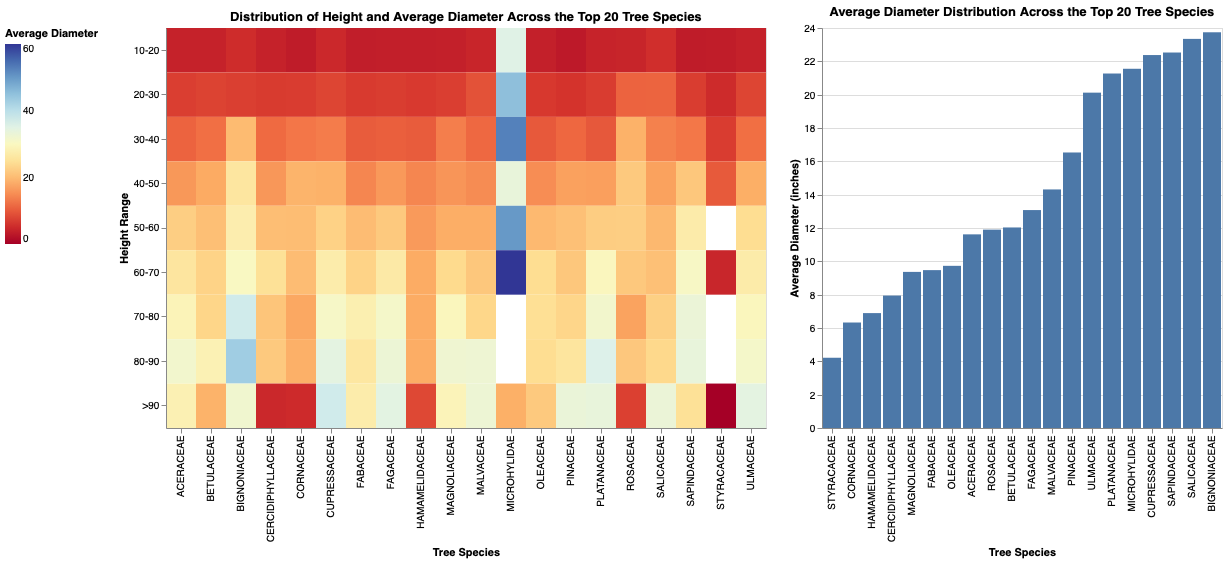

In [3]:
# Select only necessary columns
tree = tree_df[["FAMILY_NAME", "HEIGHT_RANGE", "DIAMETER", "HEIGHT_SIZE", "STREET_SIDE_NAME", "LATITUDE"]]

top_20_species = tree['FAMILY_NAME'].value_counts().head(20).index.tolist()

# Filter data for top 20 family species
top_20_tree_species  = tree[tree['FAMILY_NAME'].isin(top_20_species)]

tree_data = top_20_tree_species.groupby(['FAMILY_NAME', 'HEIGHT_RANGE']).agg(
    avg_diameter=('DIAMETER', 'mean'),
    tree_count=('HEIGHT_RANGE', 'size')  # Count all entries in group
).reset_index().dropna()

# Shared Selection for Tree Species (Click)
species_selection = alt.selection_point(fields=['FAMILY_NAME'], name="species_select")


diameter_slider = alt.binding_range(min=0, max=61, step=1, name="Min Avg Diameter: ")
diameter_selection = alt.param(bind=diameter_slider, value=0)
reset_button = alt.param(name="reset_diameter", bind=alt.binding_checkbox(name="Reset Diameter"), value=False)

heatmap = alt.Chart(tree_data).mark_rect().encode(
    alt.X('FAMILY_NAME:N', title='Tree Species'),
    alt.Y('HEIGHT_RANGE:N', title='Height Range'),
    alt.Color('avg_diameter:Q', title='Average Diameter', scale=alt.Scale(scheme='redyellowblue'), legend=alt.Legend(orient="left")),
    opacity=alt.condition(
        species_selection & ((alt.datum.avg_diameter >= diameter_selection) | reset_button),
        alt.value(1),  # Highlight selected boxes
        alt.value(0.3)  # Dim non-selected boxes
    ),
    tooltip=[
        alt.Tooltip('FAMILY_NAME:N', title='Species'),
        alt.Tooltip('HEIGHT_RANGE:N', title='Height Range'),
        alt.Tooltip('avg_diameter:Q', title='Avg Diameter', format='.1f'),
        alt.Tooltip('tree_count:Q', title='Tree Count')
    ]
).add_params(species_selection, diameter_selection, reset_button).properties(
    title='Distribution of Height and Average Diameter Across the Top 20 Tree Species',
    width=600,
    height=400
)

avgdia_tree_dist = alt.Chart(top_20_tree_species).mark_bar().encode(
    alt.X("FAMILY_NAME:N", title="Tree Species", sort="y"),
    alt.Y("average(DIAMETER):Q", title="Average Diameter (inches)", aggregate="mean"),
    opacity=alt.condition(species_selection, alt.value(1), alt.value(0.3)),
    tooltip=['FAMILY_NAME:N', alt.Tooltip('average(DIAMETER):Q', title='Avg Diameter', format='.1f')]
).add_params(species_selection).properties(
    title="Average Diameter Distribution Across the Top 20 Tree Species",
    height=400,
    width=400
)

# Combine Charts
viz1 = heatmap | avgdia_tree_dist
viz1

In [4]:
html_file = "../../images/bri_viz/sustainability_viz1.html"
viz1.save(html_file)

### Justification of Visualization Choices

#### Marks:

- **Heatmap**: Used to compare tree diameters across different height ranges and species. The color intensity effectively illustrates variations in diameter at various heights, making patterns and outliers easily identifiable.


- **Bar Chart**: Used to show the average tree diameter for the top 20 species. The height of each bar allows for straightforward comparisons of tree species regarding diameter, making it easy to rank them.

#### Channels:

**Heatmap**: 

- **Position**:
    - X-axis represents different tree species
    - Y-axis denotes height ranges.

- **Color:**  
  A sequential color scale using the scheme red, yellow, and blue is employed. Colors represent varying values of average diameter: red indicates smaller diameters, yellow signifies intermediate sizes, and blue represents larger diameters.

- **Opacity:**  
  Based on the selections made (species that are selected or hovered over), if the average diameter exceeds the threshold set via the slider, the opacity of the corresponding rectangles is set to 1 (highlighted). Non-selected boxes are dimmed to an opacity of 0.3.

- **Tooltip:**  
  Each tooltip provides additional information, including the total tree count, species, height range, and average diameter, enhancing the interpretability of the heatmap.

**Bar Chart**: 
- **Position**:
    - X-axis represents tree species
    - Y-axis indicates their average diameter, promoting an intuitive understanding of size differences.
  
- **Length:** The height of the bars represents the average diameter for each tree species, arranged in ascending order. This sorting simplifies the identification of species with the largest and smallest diameters.

- **Opacity:** When a species is selected, its bar is fully visible (opacity set to 1). For all other species, the bar's opacity is dimmed to 0.3.

- **Tooltip:** The tooltip provides details such as tree species and average diameter, enhancing the interpretability of the data.

#### Interaction and UI Widgets


- **Diameter Slider:** This slider allows users to filter heatmap cells by setting a minimum average diameter (avg_diameter) for the tree species they wish to explore.


- **Reset Button:** This button resets the diameter filter to its default state (minimum diameter set to 0). When activated, it restores visibility for all species in the visualizations.


- **Bidirectional Linking:** Users can click on a specific species in either the heatmap or bar chart to select it. Once selected, the species is highlighted in both plots, allowing users to focus on a specific tree species and observe its distribution across both visualizations simultaneously.


- **Conditional Highlighting:** The selected tree species is highlighted in full opacity, while other species are dimmed. This feature enhances focus and reduces visual clutter.


- **Tooltip Enhancements:** Tooltips provide precise numerical values for tree counts, height ranges, and average diameter, improving interpretability while maintaining a clean visualization.

#### Tasks Supported by the Visualization

1. **Retrieve Value:** Tooltips allow users to extract specific details about the tree species, including their average diameter, tree count, height range, and species name.

2. **Characterize Distribution:** Analyze the distribution of tree diameters across different species and height ranges to understand how these factors compare among the various species.

3. **Filter:** Users can filter the data based on criteria such as minimum average diameter (using a slider) and specific species selections (via click).

4. **Compute Derived Value:** Aggregated metrics, such as average diameter and tree count per species and height range, are computed and displayed, providing insights into the characteristics of tree populations.

5. **Find Extremum:** Identify species with the largest and smallest average diameters, and examine which height ranges correspond to these extreme values.

6. **Determine Range:** Identify the range of tree diameters within each species and height category.

7. **Find Anomalies:** Detect any species that exhibit unexpectedly high or low diameters at specific heights.

8. **Sort:** Rank tree species by average diameter in ascending order.

#### Why These Choices Were Effective

1. **Data Processing:**  
- Aggregating the data by species and height combination helps summarize the relationship between species, their height ranges, and average diameters. This method allows for easy comparison across different species, helping users understand how height and diameter vary for each type.
- The filter that shows only the top 20 families ensures that the visualization emphasizes the most significant species in terms of their presence in Vancouver’s public spaces. This approach prevents users from being overwhelmed by less-representative species and instead highlights those that the public interacts with most frequently.

2. **Comprehensive Analysis:**  
- The heatmap provides a spatial overview of how height ranges and average diameters are distributed across tree species. This enables users to visually identify trends, such as which species tend to be taller or have larger diameters.
- The bar chart complements the heatmap by offering a detailed view of the average diameter per species, sorted by species name. This visualization clarifies how diameters differ among species, offering insight into which species are larger or smaller and allowing users to dive deeper into individual species for more details.

3. **Dynamic Exploration:**  
- **Species Selection:** Users can explore specific species in more detail through click interactions. This feature allows them to see how the diameter and height of a selected species compare to others. 
- **Average Diameter Slider:** The slider enhances users' ability to focus on specific subsets of the data, particularly regarding tree diameters.
- **Conditional Highlighting:** This feature improves focus on selected species or height ranges, reducing cognitive load and making it easier to visually assess how specific trees or species compare in terms of size characteristics.

4. **Enhanced Interpretability:**  
- Tooltips provide users with direct access to key information such as species name, height range, average diameter, and tree count. This clarity ensures that users understand the data points they are interacting with.
- The opacity changes on hover or selection help guide the user’s attention to the most relevant data, improving the clarity of comparisons between species.

## Visualization 2:
### How does the spatial distribution of the physical traits of species differ across Vancouver?

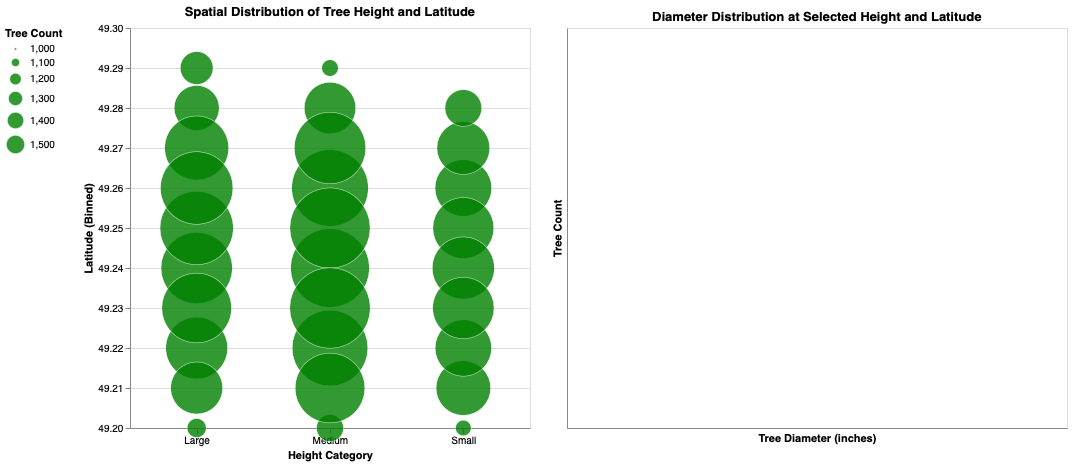

In [5]:
diameter_slider = alt.binding_range(min=3, max=100, step=5, name="Min Diameter: ")
diameter_selection = alt.param(bind=diameter_slider, value=10)

threshold_slider = alt.selection_point(
    fields=['threshold'],
    bind=alt.binding_range(
        min=1300, max=10100, step=200,
        name='Min Tree Count:'
    ),
    value=1300  # Default value
)

dot_selection = alt.selection_point(
    fields=['HEIGHT_SIZE', 'latitude_bin'],
    on='click',
    empty = "none",
    name="Selected Dot"
)

# Scatter Plot (Latitude vs. Height Category)
scatter = alt.Chart(top_20_tree_species).transform_bin(
    'latitude_bin', 'LATITUDE', bin=alt.Bin(step=0.01)
).transform_aggregate(
    avg_diameter='mean(DIAMETER)',
    count='count()',
    groupby=['HEIGHT_SIZE', 'latitude_bin']
).transform_calculate(
    jitter="sqrt(-2*log(random()))*cos(2*PI*random()) * 0.2"
).mark_circle(
    opacity=0.8,
    stroke='white',
    strokeWidth=0.5
).encode(
    y=alt.Y('latitude_bin:Q', title='Latitude (Binned)', scale=alt.Scale(domain=[49.2, 49.3])),
    x=alt.X('HEIGHT_SIZE:N', title='Height Category', axis=alt.Axis(labelAngle=0)),
    size=alt.Size('count:Q', title='Tree Count', scale=alt.Scale(domain=[1000,1500]), legend = alt.Legend(orient="left")),
    color=alt.condition(dot_selection, alt.value("red"), alt.value("green")),  # Highlight selected category
    tooltip=[
        alt.Tooltip('latitude_bin:Q', title='Latitude', format='.4f'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Category'),
        alt.Tooltip('avg_diameter:Q', title='Avg Diameter (inches)', format='.1f'),
        alt.Tooltip('count:Q', title='Tree Count')
    ]
).add_params(
    dot_selection
).properties(
    title="Spatial Distribution of Tree Height and Latitude",
    width=400,
    height=400
)

scatter = scatter.transform_filter(
    alt.datum.count >= threshold_slider.threshold
).add_params(threshold_slider)


species_chart = alt.Chart(top_20_tree_species).mark_bar().transform_bin(
    'latitude_bin', 'LATITUDE', bin=alt.Bin(step=0.01)).encode(
    x=alt.X('DIAMETER:Q', bin=alt.Bin(maxbins=50), title="Tree Diameter (inches)"),
    y=alt.Y('count()', title="Tree Count"),
    tooltip=[
        alt.Tooltip('HEIGHT_SIZE:N', title="Height Category"),
        alt.Tooltip('count():Q', title="Tree Count"),
        alt.Tooltip('latitude_bin:Q', title='Latitude', format='.4f'),
        alt.Tooltip('DIAMETER:Q', title='Tree Diameter')
    ]).transform_filter(dot_selection
).properties(
    title="Diameter Distribution at Selected Height and Latitude",
    width=500,
    height=400
)

species_chart = species_chart.add_params(diameter_selection).transform_filter(
    alt.datum.DIAMETER >= diameter_selection
) 

viz2 = scatter | species_chart
viz2

In [6]:
html_file = "../../images/bri_viz/sustainability_viz2.html"
viz2.save(html_file)

### Justification of Visualization Choices

#### Marks:
1. Scatter Plots: Used to represent tree diameters at different latitudes for various height categories. Each point represents an aggregated average, making spatial trends clear.
2. Bar Charts: Used to display the dominant species within each height category. This allows for easy comparison of species distribution across different tree sizes.

#### Channels:
**Scatter Plot**
- **Position**:
    - X-axis represents different height categories (small, medium, large)
    - Y-axis encodes the binned latitude as a quantitative value along the y-axis. Latitude is binned into small intervals (step = 0.01) to smooth the distribution.

- **Size**: The size of the circles represents the number of trees in a given height and latitude bin, with a specific scale for tree count.

- **Color:** The color of the circles is determined by whether the point is selected (via dot selection). Selected dots are colored red, while unselected dots are green, highlighting the interactive selection.

- **Tooltip:** Provides additional information on hover, including latitude, height category, average diameter, and tree count.

**Bar Chart**
- **Position:**
    - X-axis represents the binned tree diameter values (maximum of 50 bins)
    - Y-axis represents the tree count in each diameter bin.

- **Tooltip:** Provides additional information on hover, including the height category, tree count, and binned latitude.

#### Interaction and UI Widgets

- **Threshold Slider:** The threshold_slider dynamically filters the scatter plot, showing only trees with a count greater than or equal to the selected threshold value.

- **Diameter Slider:** The diameter_selection slider filters the species chart to display only those trees with a diameter greater than or equal to the selected value.

- **Dot Selection:** The dot_selection enables the user to select a specific group of trees by clicking on a scatter plot point. The selected trees' height and latitude values are then used to filter the species chart.

- **Linked Filtering:**
1. As the threshold slider value changes, the scatter plot updates in real-time to reflect the data points that meet the tree count criteria. This allows users to focus on areas with higher tree counts.
2. As the diameter slider value changes, the bar chart updates in real-time to reflect the data points that meet the minimum diameter criteria.
3. Once a point is selected in the scatter plot, the species chart (bar chart) updates to display only data that corresponds to the selected height category and latitude bin.   

- **Conditional Highlighting:** When a point is selected, its color changes from green (default) to red, visually indicating the selection. The species chart then updates to display the diameters of trees corresponding to the selected height and latitude bins.

- **Tooltip Enhancements:** Tooltips provide precise numerical values for tree counts, average diameter, and latitude bin improving interpretability while maintaining a clean visualization.

#### Tasks Supported by the Visualization

1. **Characterize Distribution:**
   - Users can explore how tree diameter distribution varies across different height and latitude categories using the bar chart (species chart).
   - The scatter plot illustrates the distribution of tree counts for each height and latitude bin.

2. **Retrieve Value:** Tooltips enable users to extract specific details about tree species, including average diameter, tree count, and height range across different latitudes.

3. **Filter:**
   - Adjusting the diameter slider filters the bar chart to display only trees with diameters greater than or equal to the selected value, allowing users to focus on specific tree sizes.
   - By selecting a specific point on the scatter plot, users can filter the bar chart to show only the tree diameter distribution for the chosen height and latitude group.

4. **Find Extremum:** Users can interact with the scatter plot to visually identify the latitude bins and heights that correspond to the largest and smallest tree counts.

5. **Determine Range:** Identify the range of tree diameters within each tree species and height category. The species chart displays the range of diameters using bars for the diameter bins. The diameter slider allows users to further filter this range, showing only the trees that fall within the selected diameter thresholds.

6. **Correlate:** Users can identify patterns or trends in tree data distribution, such as whether trees in certain height categories are concentrated in specific latitudes or whether diameter distributions differ significantly across groups.

#### Why These Choices Were Effective

1. **Comprehensive Analysis:**  
- The scatter plot, when used in combination with the latitude binning, directly answers the question of how the spatial distribution (latitude) influences the physical traits (height and diameter) of tree species. Users can quickly observe trends such as which species tend to be taller or have larger diameters at specific latitudes.
- The bar chart complements this analysis by providing a more focused view of the diameter distribution for specific height categories and species. Users can compare the average diameters and see how species vary in size across different latitudes.

2. **Dynamic Exploration:**  
- **Threshold Slider:** The slider allows users to set a threshold for the minimum tree count. As users adjust the slider, the chart updates in real-time to show only the points where the tree count meets or exceeds the specified threshold.
- **Diameter Slider:** The Diameter Slider provides a way to filter data based on the diameter of the trees. It lets users focus on a specific range of tree sizes.
- **Dot Selection:** Dot Selection allows users to click on specific dots in the scatter plot, which represent trees in a particular height and latitude range. It provides a mechanism for selecting and filtering data interactively.
- **Conditional Highlighting:** Conditional Highlighting helps users visually distinguish between selected and unselected data points based on their interactions. This increases the visibility of the elements the user is focusing on and improves the overall clarity of the visualization.

3. **Enhanced Interpretability:**  
- Tooltips provide users with direct access to key information such as tree count, height range and average diameter. This clarity ensures that users understand the data points they are interacting with.

### Visualization 3: 
#### How do height and diameter of tree influence their placement in different urban settings (e.g., streets, parks, medians, and greenways)?


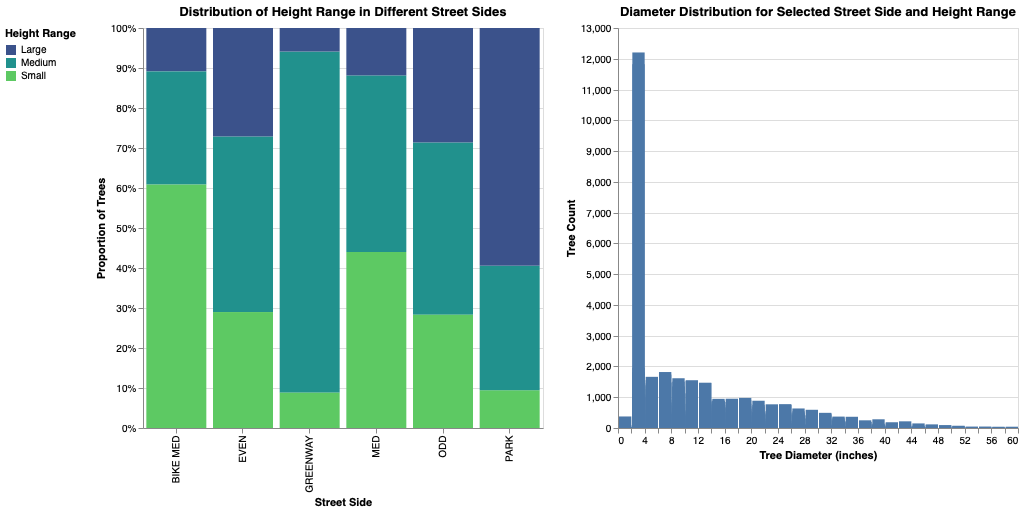

In [7]:
# Subset data for trees with diameter < 60
diameter_50 = top_20_tree_species[
    (top_20_tree_species["DIAMETER"] < 60) & (top_20_tree_species["DIAMETER"].notna())
]

# Radio button for height selection
height_radio = alt.binding_radio(
    options=["Show All", "Small", "Medium", "Large"], name="Height: "
)

height_selection = alt.param(
    name="height_selection",
    bind=height_radio,
    value="Show All"  # Default selection
)

# Radio button for street selection
street_radio = alt.binding_radio(
    options=["Show All"] + list(diameter_50['STREET_SIDE_NAME'].unique()), name="Street Side: "
)

street_selection = alt.param(
    name="street_selection",
    bind=street_radio,
    value="Show All"  # Default selection
)

# Bar chart for height distribution by street
height_bar = alt.Chart(diameter_50).mark_bar().encode(
    alt.X("STREET_SIDE_NAME:N", title="Street Side"),
    alt.Y("count():Q", stack="normalize", title="Proportion of Trees"),
    alt.Color("HEIGHT_SIZE:N", 
          scale=alt.Scale(scheme="viridis"), 
          title="Height Range",
          legend=alt.Legend(orient="left")),
    opacity=alt.condition(
        ((alt.datum.HEIGHT_SIZE == height_selection) | (height_selection == "Show All")) &
        ((alt.datum.STREET_SIDE_NAME == street_selection) | (street_selection == "Show All")),
        alt.value(1),  # Highlight selected
        alt.value(0.3)  # Dim others
    ),
    tooltip=[
        alt.Tooltip('STREET_SIDE_NAME:N', title='Street Side'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Size'),
        alt.Tooltip('count():Q', title='Count of Tree')
    ]
).add_params(height_selection, street_selection).properties(
    title="Distribution of Height Range in Different Street Sides",
    height=400,
    width=400
)

# Histogram for diameter distribution
diameter_hist = alt.Chart(diameter_50).mark_bar().encode(
    alt.X("DIAMETER:Q", bin=alt.Bin(maxbins=30), title="Tree Diameter (inches)"),
    alt.Y("count():Q", title="Tree Count"),
    tooltip=[
        alt.Tooltip('STREET_SIDE_NAME:N', title='Street Side'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Size'),
        alt.Tooltip('count():Q', title='Count of Tree'),
        alt.Tooltip('DIAMETER:Q', title='Diameter')
    ]
).transform_filter(
    ((alt.datum.HEIGHT_SIZE == height_selection) | (height_selection == "Show All")) &
    ((alt.datum.STREET_SIDE_NAME == street_selection) | (street_selection == "Show All"))
).properties(
    title="Diameter Distribution for Selected Street Side and Height Range",
    height=400,
    width=400
)

viz3 = height_bar | diameter_hist
viz3

In [8]:
html_file = "../../images/bri_viz/sustainability_viz3.html"
viz3.save(html_file)

### Justification of Visualization Choices

#### Marks:
1. Stacked Bar Chart: Used to compare tree height categories (small, medium, large) across different street sides. The stacked format allows for a direct proportional comparison across categories.
2. Histogram: Used to represent the frequency distribution of tree diameters for the selected street side and height category. The binning approach in the histogram effectively shows the distribution of tree sizes.

#### Channels:
**Stacked Bar Chart**
- **Position**:
    - X-axis represents different street side
    - Y-axis represents relative proportions of different height ranges (small, medium, large)

- **Color:** The color of the bar is represented by different height ranges

- **Opacity:** Encodes the opacity of each bar, which changes based on the selection of height size (height_selection) and street side (street_selection). Selected values are fully visible (opacity = 1), and others are dimmed (opacity = 0.3).

- **Tooltip:** Provides additional information on hover, including height category, diameter, steer side and tree count.

**Bar Chart**
- **Position:**
    - X-axis represents the diameter of trees). This axis is divided into bins with a maximum of 30 bins.
    - Y-axis represents the tree count in each diameter bin.

- **Tooltip:** Provides additional information on hover, including height category, diameter, steer side and tree count.

#### Interaction and UI Widgets

- **Height Selection Radio Button:** This widget allows the user to select a height range for the trees. The options "Small," "Medium," and "Large" correspond to the HEIGHT_SIZE variable, while the "Show All" option displays all tree heights, regardless of the size.

- **Street Selection Radio Button:** This widget allows the user to select a street side (or choose "Show All" to include all streets). The street sides are dynamically populated based on the dataset, and users can pick a specific street side for analysis.

- **Linked Filtering:**
1. The height selection filters both visualizations to display only data corresponding to the selected street side (or all street sides if "Show All" is selected).
2. The street selection filters both visualizations to display only data corresponding to the selected street side (or all street sides if "Show All" is selected).

- **Conditional Highlighting:**
1. The height selection controls the opacity of the bars in the height_bar chart. Trees of the selected height range are fully visible, while trees outside the selection are dimmed.
2. The street selection filters both visualizations to display only data corresponding to the selected street side (or all street sides if "Show All" is selected).

- **Tooltip Enhancements:** Tooltips provide precise numerical values for tree counts, average diameter, and improving interpretability while maintaining a clean visualization.

#### Tasks Supported by the Visualization

1. **Characterize Distribution:**  The height distribution allows users to see which sides of the street have a greater number of trees within specific height ranges.

2. **Filter:** Filtering by tree diameter ensures that the visualization only displays relevant data, specifically trees with diameters under 60 cm. Users can also filter by street side for more precise information.

3. **Retrieve Value:**  Tooltips enable users to extract detailed information about the average diameter, tree count, and height range for different sides of the street.

4. **Compute Derived Value:**  Calculate the total number of trees for each street side and height category.

5. **Find Extremum:**  The stacked bars allow users to easily compare the relative proportions of different height categories on each side of the street.

6. **Determine Range:**  The histogram bins for each street side display the range of tree diameters within each selected height category. Users can visually assess the distribution of tree diameters for each side of the street by selecting different height categories using radio buttons.

7. **Find Anomalies:** Identify any unusual diameter distribution patterns that may exist for specific combinations of street sides and height ranges.

#### Why These Choices Were Effective

1. **Comprehensive Analysis:**  
- The stacked bar chart represents the count of trees in each height category (Small, Medium, Large) across various street sides (urban settings). This allows users to compare how different height categories are distributed across the urban settings.
- The bar chart (histogram) visually shows the distribution of tree diameters across different settings. By binning the diameter data, users can observe the prevalence of certain tree sizes across urban locations.

2. **Dynamic Exploration:**
- **Height Selection Radio Button**: Users can filter by height categories (Small, Medium, Large) or choose "Show All" to view all trees regardless of height. This enables focused exploration of how different height ranges are distributed across various street sides.
- **Street Side Selection:** Users can filter by specific urban settings (e.g., streets, parks, greenways), which allows them to explore how trees of different heights and diameters are placed in these settings.
- **Conditional Highlighting:** Conditional Highlighting helps users visually distinguish between selected and unselected combinations based on their interactions. This increases the visibility of the elements the user is focusing on and improves the overall clarity of the visualization.

3. **Enhanced Interpretability:**  
- Tooltips provide users with direct access to key information such as tree count, height range, street side and average diameter. This clarity ensures that users understand the data points they are interacting with.